<a href="https://colab.research.google.com/github/sourcecode369/TensorFlow-2.0/blob/master/tensorflow_2.0_docs/TensorFlow%20Core/Tutorials/Images/Image%20Segmentation/Kaggle_Nuclei_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%%time
!pip install --upgrade tensorflow-gpu

     |████████████████████████████████| 380.8MB 41kB/s 
     |████████████████████████████████| 450kB 44.5MB/s 
     |████████████████████████████████| 3.8MB 27.7MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.6.3 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled googl

CPU times: user 4.84 s, sys: 878 ms, total: 5.71 s
Wall time: 54.2 s


In [1]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle 
!chmod 600 ~/.kaggle/kaggle.json 
!kaggle competitions download -c data-science-bowl-2018

Saving kaggle.json to kaggle.json
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.35MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 88.4MB/s]
 99% 9.00M/9.10M [00:01<00:00, 7.69MB/s]
100% 9.10M/9.10M [00:01<00:00, 6.28MB/s]
 94% 74.0M/79.1M [00:02<00:00, 26.7MB/s]
100% 79.1M/79.1M [00:02<00:00, 35.8MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 93.0MB/s]
100% 275M/276M [00:04<00:00, 73.6MB/s]
100% 276M/276M [00:04<00:00, 59.2MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 53.2MB/s]


In [15]:
!ls -GFlash --color

total 264K
4.0K drwxr-xr-x   1 root 4.0K Oct 30 12:13 ./
4.0K drwxr-xr-x   1 root 4.0K Oct 30 11:29 ../
4.0K drwxr-xr-x   1 root 4.0K Oct 28 15:16 .config/
4.0K -rw-r--r--   1 root   64 Oct 30 11:33 kaggle.json
168K -rw-r--r--   1 root 167K Oct 30 12:13 model.png
4.0K drwxr-xr-x   1 root 4.0K Oct 25 16:58 sample_data/
 76K drwxr-xr-x 672 root  72K Oct 30 11:33 stage1_train/


In [0]:
import zipfile
files = ["stage1_train.zip","stage1_train_labels.csv.zip"]
for f in files:
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall("stage1_train")

In [4]:
!ls -GFlash --color 
!rm -rf stage1_train.zip
!rm -rf stage1_train_labels.csv.zip
!rm -rf stage1_test.zip
!rm -rf stage1_sample_submission.csv.zip
!rm -rf stage1_solution.csv.zip
!rm -rf stage2_test_final.zip
!rm -rf stage2_sample_submission_final.csv.zip

total 368M
4.0K drwxr-xr-x   1 root 4.0K Oct 30 11:33 ./
4.0K drwxr-xr-x   1 root 4.0K Oct 30 11:29 ../
4.0K drwxr-xr-x   1 root 4.0K Oct 28 15:16 .config/
4.0K -rw-r--r--   1 root   64 Oct 30 11:33 kaggle.json
4.0K drwxr-xr-x   1 root 4.0K Oct 25 16:58 sample_data/
4.0K -rw-r--r--   1 root 2.7K Oct 30 11:33 stage1_sample_submission.csv.zip
388K -rw-r--r--   1 root 387K Oct 30 11:33 stage1_solution.csv.zip
9.2M -rw-r--r--   1 root 9.2M Oct 30 11:33 stage1_test.zip
 76K drwxr-xr-x 672 root  72K Oct 30 11:33 stage1_train/
2.7M -rw-r--r--   1 root 2.7M Oct 30 11:33 stage1_train_labels.csv.zip
 80M -rw-r--r--   1 root  80M Oct 30 11:33 stage1_train.zip
116K -rw-r--r--   1 root 113K Oct 30 11:33 stage2_sample_submission_final.csv.zip
277M -rw-r--r--   1 root 277M Oct 30 11:33 stage2_test_final.zip


In [17]:
%%time
%load_ext tensorboard
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import os
os.environ["PYTHONHASHSEED"] = str(1)

import gc
gc.enable()

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from cv2 import resize
import seaborn as sns

import tensorflow as tf

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 10.8 ms, sys: 1.9 ms, total: 12.7 ms
Wall time: 13 ms


In [0]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

DATA_PATH = 'stage1_train/'
seed = 2019

In [0]:
np.random.seed(seed)
tf.random.set_seed(seed)

In [0]:
image_ids = next(os.walk(DATA_PATH))[1]

In [0]:
X = np.zeros((len(image_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(image_ids),IMG_HEIGHT, IMG_WIDTH,1),dtype=np.bool)

In [22]:
for n, id_ in tqdm(enumerate(image_ids),total=len(image_ids)):
    path = DATA_PATH + id_
    img = imread(path+'/images/'+id_+'.png')[:,:,:IMG_CHANNELS]
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH))
    X[n] = img
    mask = np.zeros((IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool)
    for mask_file in next(os.walk(path+'/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH)), axis=-1)
        mask = np.maximum(mask, mask_)
    Y[n] = mask

100%|██████████| 670/670 [00:43<00:00, 15.52it/s]


In [0]:
x_train = X
y_train = Y

In [24]:
print(f'X_train shape: {x_train.shape}, Y_train shape: {y_train.shape}')

X_train shape: (670, 128, 128, 3), Y_train shape: (670, 128, 128, 1)


![unet](https://i1.wp.com/androidkt.com/wp-content/uploads/2019/04/Selection_062.png?resize=768%2C561&ssl=1)

In [42]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32) / 255.0)(inputs)

c1 = tf.keras.layers.Conv2D(16,(3,3),activation=tf.keras.activations.elu, kernel_initializer="he_normal", padding="same")(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation=tf.keras.activations.elu, kernel_initializer="he_uniform", padding="same")(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32,(3,3),activation=tf.keras.activations.elu, kernel_initializer="he_normal", padding="same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation=tf.keras.activations.elu, kernel_initializer="he_uniform", padding="same")(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3),activation=tf.keras.activations.elu, kernel_initializer="he_normal", padding="same")(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation=tf.keras.activations.elu, kernel_initializer="he_uniform", padding="same")(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128,(3,3),activation=tf.keras.activations.elu, kernel_initializer="he_normal", padding="same")(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.activations.elu, kernel_initializer="he_uniform", padding="same")(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256,(3,3),activation=tf.keras.activations.elu, kernel_initializer="he_normal", padding="same")(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation=tf.keras.activations.elu, kernel_initializer="he_uniform", padding="same")(c5)
p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)

u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2),padding="same")(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.activations.elu, kernel_initializer="he_uniform",padding="same")(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.activations.elu, kernel_initializer="he_uniform",padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2),padding="same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation=tf.keras.activations.elu, kernel_initializer="he_uniform",padding="same")(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation=tf.keras.activations.elu, kernel_initializer="he_uniform",padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2),padding="same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1],axis=3)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation=tf.keras.activations.elu, kernel_initializer="he_uniform",padding="same")(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation=tf.keras.activations.elu, kernel_initializer="he_uniform",padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1),activation="sigmoid")(c9)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss="binary_crossentropy",metrics=["accuracy"])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 16) 448         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 128, 128, 16) 0           conv2d_57[0][0]                  
____________________________________________________________________________________________

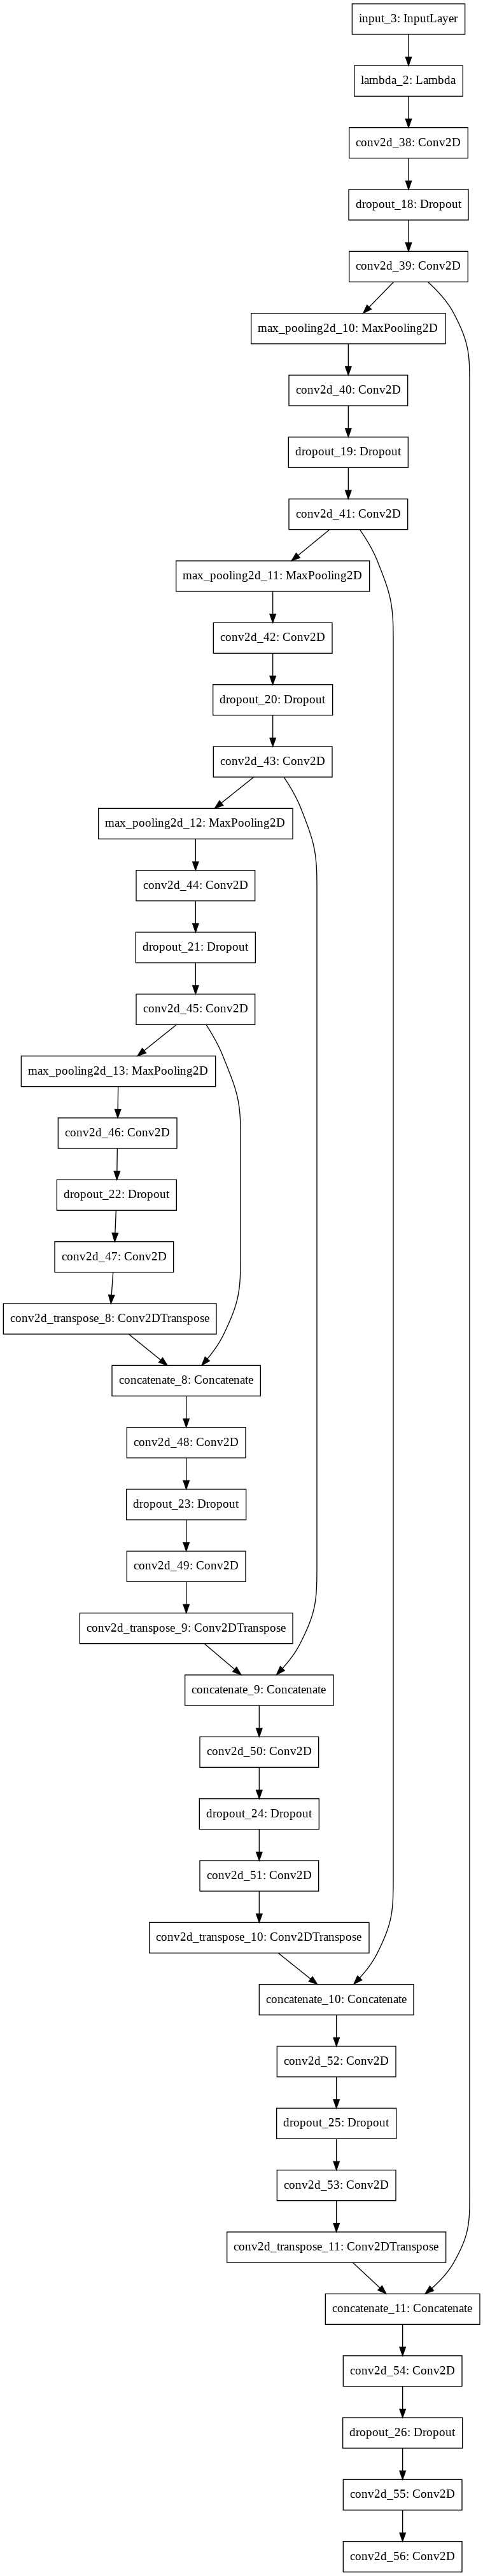

In [32]:
tf.keras.utils.plot_model(model)

In [0]:
weight_path = "{}_weights.best.hdf5".format('nuclei')
cp_callback = tf.keras.callbacks.ModelCheckpoint(weight_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1,
                                                monitor="val_loss")

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,verbose=1)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir = "logs")

def decay(epoch):
    if epoch < 5:
        return 1e-3
    elif epoch >5 and epoch < 10:
        return 1e-4
    else:
        return 1e-5

lr_callback = tf.keras.callbacks.LearningRateScheduler(decay,verbose=1)

callbacks = [
             cp_callback, 
             es_callback,
             tb_callback,
             lr_callback
        ]

In [45]:
history = model.fit(x_train, 
          y_train, 
          validation_split=0.1, 
          batch_size=16, 
          epochs=15,
          callbacks=callbacks,
          verbose=1)

Train on 603 samples, validate on 67 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/15
592/603 [============================>.] - ETA: 0s - loss: 0.1043 - accuracy: 0.9598
Epoch 00001: val_loss did not improve from 0.10688
603/603 [==============================] - 5s 8ms/sample - loss: 0.1035 - accuracy: 0.9601 - val_loss: 0.1189 - val_accuracy: 0.9501

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/15
592/603 [============================>.] - ETA: 0s - loss: 0.1074 - accuracy: 0.9585
Epoch 00002: val_loss did not improve from 0.10688
603/603 [==============================] - 5s 8ms/sample - loss: 0.1077 - accuracy: 0.9583 - val_loss: 0.1159 - val_accuracy: 0.9538

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/15
592/603 [============================>.] - ETA: 0s - loss: 0.0991 - accuracy: 0.9621
Epoch 00003: val_loss improved from 0.10688 to 0.10602, saving model to nuclei_weights.best.

In [47]:
model_history = pd.DataFrame(history.history)
model_history["epoch"] = history.epoch
model_history.head()

,loss,accuracy,val_loss,val_accuracy,lr,epoch
0,0.103512,0.960124,0.118851,0.950096,0.001,0
1,0.107712,0.958274,0.115927,0.953753,0.001,1
2,0.098695,0.962220,0.106018,0.954155,0.001,2
3,0.088714,0.965605,0.099899,0.956309,0.001,3
4,0.085239,0.966445,0.093042,0.960415,0.001,4


In [51]:
import plotly.graph_objs as go
import plotly.offline as pyo

trace0 = go.Scatter(x=model_history["epoch"], y=model_history["accuracy"],
                    mode="markers+lines",name="Training Accuracy")

trace1 = go.Scatter(x=model_history["epoch"], y=model_history["val_accuracy"],
                    mode="markers+lines",name="Validation Accuracy")

data = [trace0, trace1]

layout = go.Layout(title="Model Training and Validation Accuracy")

fig = go.Figure(data=data, layout=layout)

pyo.iplot(fig)

In [53]:

trace0 = go.Scatter(x=model_history["epoch"], y=model_history["loss"],
                    mode="markers+lines",name="Training Loss")

trace1 = go.Scatter(x=model_history["epoch"], y=model_history["val_loss"],
                    mode="markers+lines",name="Validation Loss")

data = [trace0, trace1]

layout = go.Layout(title="Model Training and Validation Loss")

fig = go.Figure(data=data, layout=layout)

pyo.iplot(fig)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning:

Low image data range; displaying image with stretched contrast.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning:

Use the colorbar set_ticks() method instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning:

Use the colorbar set_ticks() method instead.



([], <a list of 0 Text yticklabel objects>)

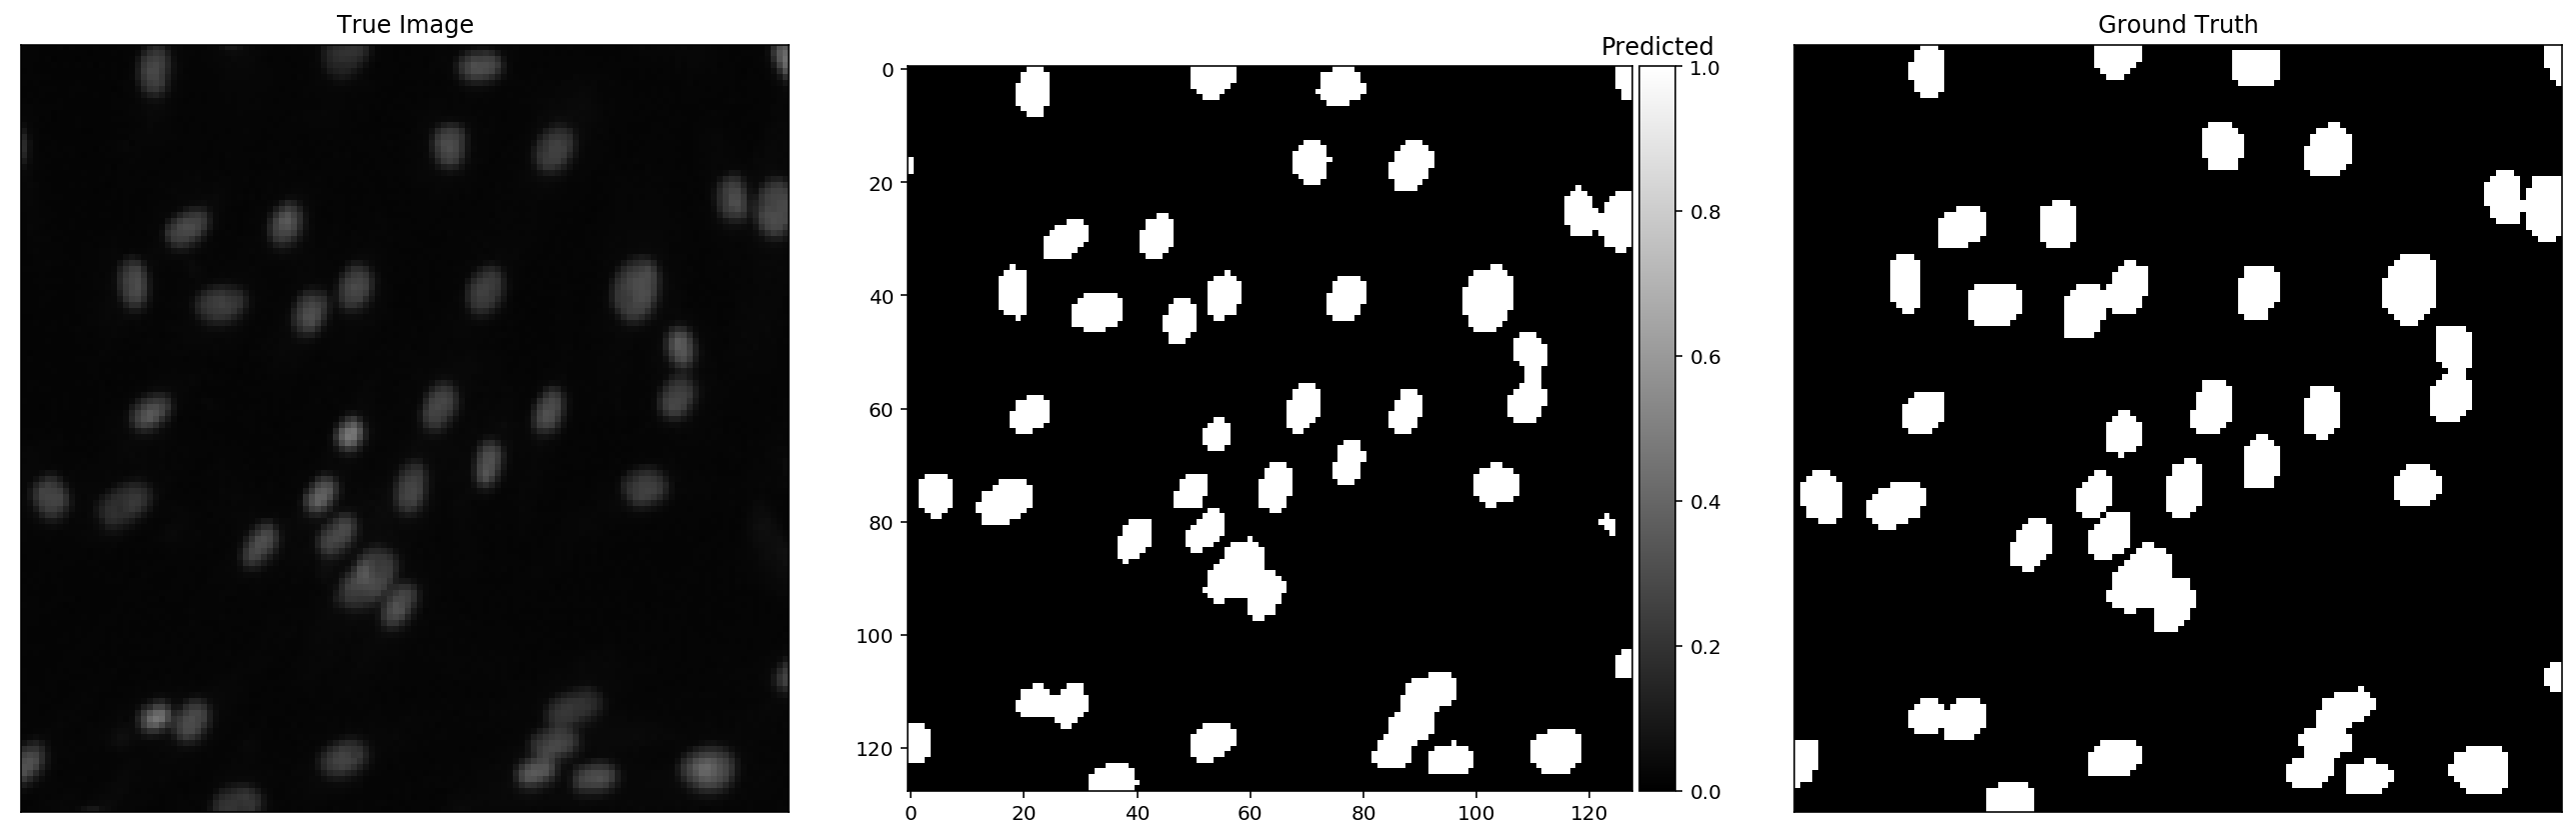

In [73]:
import random

idx = random.randint(0, len(x_train)-1)

x=np.array(x_train[idx])

x=np.expand_dims(x, axis=0)

predict = model.predict(x, verbose=0)

predict = (predict > 0.5).astype(np.uint8)
plt.figure(figsize=(18,16))

plt.subplot(1,3,1)
imshow(x_train[idx])
plt.title("True Image")
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,2)
imshow(np.squeeze(predict[0]),cmap='gray')
plt.title("Predicted")
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,3)
imshow(np.squeeze(y_train[idx]))
plt.title("Ground Truth")
plt.xticks([])
plt.yticks([])